In [242]:
import math
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import skimage.transform as sktr
import skimage.color as color
import skimage.io as skio
import scipy.misc
from scipy import signal
import scipy
plt.rcParams['image.cmap'] = 'gray'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Functions

In [243]:
def gradientx(img):
    gx = np.array([[-1,1]])
    gcx = signal.fftconvolve(img, gx, mode='same')*255.
    return gcx
def gradienty(img):
    gy = np.array([[-1],[1]])
    gcy = signal.fftconvolve(img, gy, mode='same')*255.
    return gcy

In [244]:
def energyfunction(img):
    x = gradientx(img)
    y = gradienty(img)
    energy = np.abs(x)+np.abs(y)
    return energy

In [245]:
def findseam(E):
    h = E.shape[0]
    w = E.shape[1]
    M = numpy.zeros((h,w))
    seam = numpy.zeros(h)
    for i in range(0,h):
        if i == 0:      
            M[i] = E[i]
        else:
            minl = [min(M[i-1][0], M[i-1][1])]
            minr = [min(M[i-1][w-2], M[i-1][w-1])]
            mins = [min(min(M[i-1][col-1], M[i-1][col]), M[i-1][col+1]) for col in xrange(1,w-1)]
            mins = minl+mins+minr
            M[i] = E[i]+mins
    for x in range(0,h): 
        x = (h-1)-x
        if x == (h-1):
            seam[x] = np.argmin([M[x,:]])
        else:
            j = seam[x+1]
            if j <= 0:
                seam[x] = seam[x+1]+np.argmin([M[x][j], M[x][j+1]])
            elif j >= w-1:
                seam[x] = seam[x+1]+(np.argmin([M[x][j-1], M[x][j]])-1)
            else:
                seam[x] = seam[x+1]+(np.argmin([M[x][j-1], M[x][j], M[x][j+1]])-1)
    return seam

In [246]:
def removeseam(energy,img,seam):
    img_t = np.copy(img)
    energy_t = np.copy(energy)
    h = img.shape[0]
    w = img.shape[1]
    img_e = np.array([np.delete(energy_t[row], seam[row], axis=0) for row in xrange(h)])
    img_n = np.array([np.delete(img_t[row], seam[row], axis=0) for row in xrange(h)])
    return img_e, img_n

In [247]:
def addseams(img,seams):
    img_t = np.copy(img)
    h = img.shape[0]
    w = img.shape[1]
    for x in range(seams.shape[1]):
        seam = seams[:,x]
        img_n = np.array([np.insert(np.delete(img_t[row],[seam[row]+x],0),[seam[row]+x],
                                    [0.5*(img_t[row][seam[row]+x]+img_t[row][max(seam[row]+x-1,0)]),
                                     0.5*(img_t[row][min(seam[row]+x+1,w-1)]+img_t[row][seam[row]+x])],0) 
                          for row in xrange(h)])
        img_t = np.copy(img_n)
    return img_n

In [248]:
def seamcarvingH(img,width,mask=None):
    w = img.shape[1]
    imgg = color.rgb2gray(img)
    energy = energyfunction(imgg)
    if mask != None:
        energy = energy+mask
    for x in range(w-width):
        seam = findseam(energy)
        energy,img = removeseam(energy,img,seam)
    return img

In [249]:
def seamcarvingH_E(img,width):
    h = img.shape[0]
    w = img.shape[1]
    k = width-w 
    img_t = np.copy(img)
    imgg = color.rgb2gray(img)
    energy = energyfunction(imgg)
    seams = numpy.zeros((h,k))
    for x in range(k):
        seam = findseam(energy)
        seams[:,x] = seam
        energy,img_t = removeseam(energy,img_t,seam)
    img = addseams(img,seams)
    return img

In [250]:
def seamcarvingV(img,height):
    v_img = np.rot90(img)
    vs = seamcarvingH(v_img,height)
    v_img = np.rot90(vs)
    v_img = np.rot90(v_img)
    v_img = np.rot90(v_img)
    return v_img

In [251]:
def seamcarvingV_E(img,height):
    v_img = np.rot90(img)
    vs = seamcarvingH_E(v_img,height)
    v_img = np.rot90(vs)
    v_img = np.rot90(v_img)
    v_img = np.rot90(v_img)
    return v_img

In [252]:
def removeobjectH(img,mask,w):
    width = img.shape[1]-w
    n_img = seamcarvingH(img,width, mask)
    n_img = seamcarvingH_E(n_img,img.shape[1])
    return n_img

In [253]:
def removeobjectV(img,mask,w):
    v_img = np.rot90(img)
    v_mask = np.rot90(mask)
    vs = removeobjectH(v_img,v_mask,w)
    v_img = np.rot90(vs)
    v_img = np.rot90(v_img)
    v_img = np.rot90(v_img)
    return v_img

## Main

/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


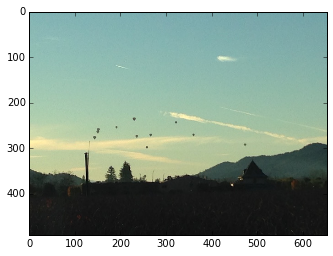

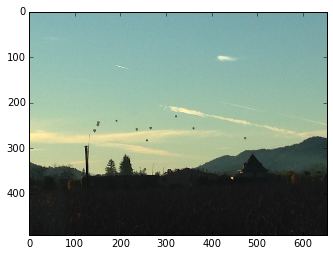

(490, 653, 3)
(490, 653, 3)


In [260]:
#import image and mask
fimg = plt.imread('ball.jpg')/255.
mask = plt.imread('mask.jpg')/255.
mask = color.rgb2gray(mask)*-1000


#Uncomment Below For Horizontal Seam Carving
# img_n = seamcarvingH(fimg, 640)

#Uncomment Below For Horizontal Seam Expansion
# img_n = seamcarvingH_E(fimg, 700)

#Uncomment Below For Vertical Seam Carving
# img_n = seamcarvingV(fimg, 480)

#Uncomment Below For Vertical Seam Expansion
# img_n = seamcarvingV_E(fimg, 500)

#Uncomment Below For Object Removal with Horizontal Seams
# img_n = removeobjectH(fimg,mask,20)

#Uncomment Below For Object Removal Vertical Seams
img_n = removeobjectV(fimg,mask,20)

plt.figure()
plt.imshow(fimg)
plt.show()
plt.figure()
plt.imshow(img_n)
plt.show()

print fimg.shape
print img_n.shape
#save the image
fname = 'out_fname.jpg'
skio.imsave(fname, img_n)